In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from formatting_data import get_data_frame, normalise
from numba import njit
from functions import reverse_normaliser
import textwrap

In [2]:
df, game_df = get_data_frame() #game_df used for identifying game using game_id
df.head(3)

,user_id,game_id,playtime
0,0,21,0.973455
1,0,23,0.999431
2,0,28,0.979734


In [3]:
user0 = df.loc[df.user_id == 0].sort_values(by='playtime', ascending=False).head(10)[['game_id', 'playtime']]
user0_games = game_df.set_index(game_df.game_id).loc[user0.game_id, 'game_name']
playtimes = user0.playtime.apply(reverse_normaliser)

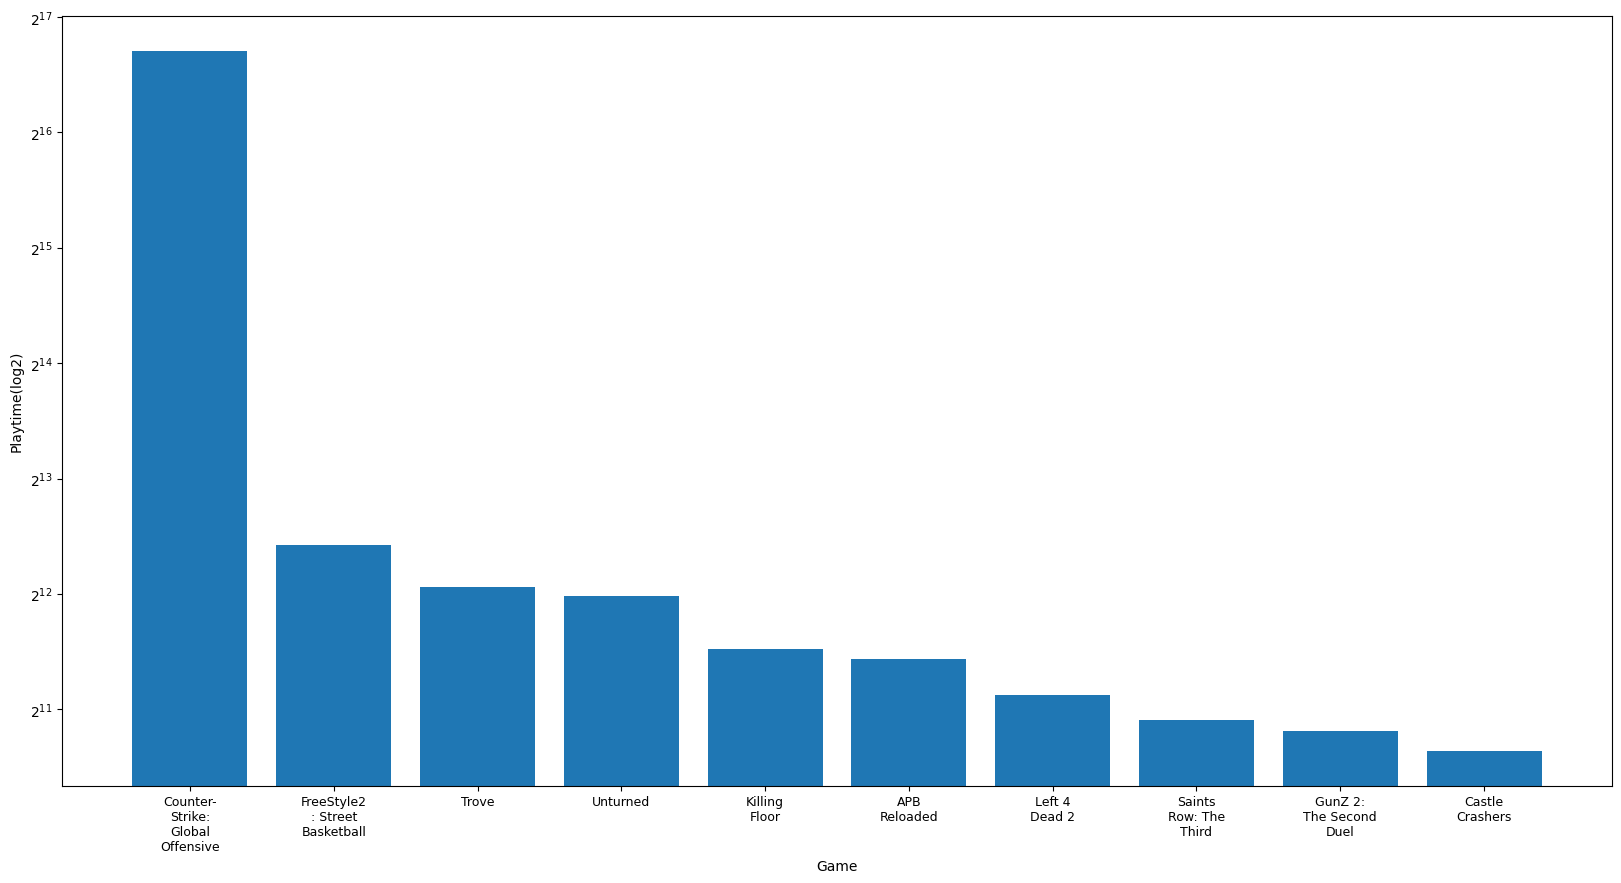

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar([textwrap.fill(label, 10) for label in user0_games[0:20]], playtimes[0:20])
ax.set_xlabel('Game')
ax.set_ylabel('Playtime(log2)')
ax.set_yscale('log', base=2)
ax.tick_params(axis='x', labelsize=9)
plt.show()
#BEWARE


In [189]:
#creating utility matrix
utility_matrix = df[0:10000].pivot_table(index=df.columns[0], columns=df.columns[1], values=df.columns[2], fill_value=0)
utility_matrix = utility_matrix.to_numpy(dtype=np.float32)

In [190]:
R = (utility_matrix != 0).astype(int)

In [191]:
num_features = 100

np.random.seed(9)

#initialising users and items features randomly
user_matrix = np.random.uniform(0,1,(utility_matrix.shape[0], num_features))
item_matrix = np.random.uniform(0,1,(utility_matrix.shape[1], num_features))
user_matrix = np.float32(user_matrix)
item_matrix = np.float32(item_matrix)

In [192]:
def cost(y, pred, R, chunk_size=500, _lambda=1.0, alpha=61.0):
    cost = (np.sum(user_matrix ** 2) + np.sum(item_matrix ** 2)) * _lambda #regularisation
    
    for i in range(0, y.shape[0], chunk_size):
        cost += np.sum(
                np.square(
                np.subtract(y[i:i+chunk_size], pred[i:i+chunk_size] * R)
            )
        )

    return cost/2
           

In [193]:
pred = user_matrix @ item_matrix.T

In [196]:
cost(utility_matrix, pred, R)

45172.83581139955

In [130]:
alpha = 0.00001
lambda_ = 0.1

In [211]:
count = 0
for i in range(1000):
    count+=1
    error = (utility_matrix - pred * R)

    item_slope = error.T @ user_matrix
    item_slope *= alpha

    user_slope = error @ item_matrix
    user_slope *= alpha

    user_matrix += user_slope
    item_matrix += item_slope

    pred = user_matrix @ item_matrix.T

    if(count % 100 == 0):
        print(cost(utility_matrix, pred, R))

769824.3986716132
560160.6252720621
434938.9059912172
353295.60488925857
296505.59035918134
255030.1097447255
223578.1158162984
199008.21199544446
179350.3130198333
163312.1540389815


In [212]:
(user_matrix @ item_matrix.T).max()

31.80095

In [213]:
pred

array([[10.2159   , 11.834356 , 10.991448 , ..., 11.792673 ,  9.328273 ,
        10.580758 ],
       [13.1826725, 17.678667 , 15.16073  , ..., 17.429558 , 13.646124 ,
        15.097811 ],
       [14.092612 , 16.799192 , 16.380064 , ..., 16.19338  , 14.854141 ,
        15.618027 ],
       ...,
       [22.989609 , 25.173311 , 25.015202 , ..., 26.799232 , 24.620522 ,
        23.61525  ],
       [16.410313 , 20.252657 , 19.370441 , ..., 18.671116 , 18.965988 ,
        20.02087  ],
       [20.209333 , 24.673054 , 25.494549 , ..., 27.056862 , 22.031633 ,
        24.622597 ]], dtype=float32)

In [110]:
utility_matrix.max()

0.99956954

In [13]:
error[0, :10]

array([-1.2839   , -0.8213886, -1.5256413, -0.8589574, -1.0578597,
       -1.4987226, -1.0684239, -1.2144983, -1.3714623, -0.7838136],
      dtype=float32)

In [14]:
utility_matrix[0, :10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [15]:
user_matrix

array([[ 4.51707393e-01, -9.06821899e-03,  6.82555437e-01,
         1.20903008e-01,  9.24074173e-01],
       [ 1.44433305e-01,  2.82720979e-02,  1.43789873e-01,
         8.30379665e-01,  7.24417746e-01],
       [ 5.64974010e-01,  4.45049375e-01,  8.84609699e-01,
         1.44629717e-01,  2.69493520e-01],
       [ 1.67529419e-01,  3.26681018e-01,  1.69405058e-01,
         6.15518153e-01,  3.93717915e-01],
       [ 2.88383931e-01,  7.12084115e-01,  8.99604321e-01,
         6.96292818e-02,  1.24546036e-01],
       [ 1.83253095e-01,  2.43893132e-01,  9.52721477e-01,
         4.26333249e-01,  7.11580217e-01],
       [ 2.12426573e-01,  1.80203527e-01,  6.45917296e-01,
         5.95520914e-01,  2.75386304e-01],
       [ 9.07202899e-01,  2.42897943e-01,  1.80510238e-01,
         6.73715115e-01,  4.89132255e-01],
       [ 3.36318076e-01,  5.59710152e-02,  1.12535208e-02,
         1.61373839e-01,  9.78693604e-01],
       [ 3.27169865e-01,  3.00707906e-01,  7.21964419e-01,
         6.61329448e-01

In [16]:
user_slope

array([[-1.47910308e-04, -1.36661823e-04, -1.51020271e-04,
        -1.42866513e-04, -1.56762093e-04],
       [-1.23957579e-04, -1.19426011e-04, -1.22798330e-04,
        -1.39139040e-04, -1.35039372e-04],
       [-1.59612857e-04, -1.54822497e-04, -1.64390774e-04,
        -1.52466077e-04, -1.53073794e-04],
       [-1.10253262e-04, -1.11424633e-04, -1.09042667e-04,
        -1.20036755e-04, -1.13981376e-04],
       [-1.36621558e-04, -1.43233876e-04, -1.47944666e-04,
        -1.33737456e-04, -1.32788220e-04],
       [-1.62026117e-04, -1.60411102e-04, -1.75797206e-04,
        -1.68843762e-04, -1.71802094e-04],
       [-1.21634082e-04, -1.18834243e-04, -1.28998494e-04,
        -1.30865083e-04, -1.22081925e-04],
       [-1.78700429e-04, -1.62756158e-04, -1.62817276e-04,
        -1.75942012e-04, -1.69704625e-04],
       [-1.05682266e-04, -9.90807384e-05, -9.80861005e-05,
        -1.02989085e-04, -1.18203541e-04],
       [-1.89724902e-04, -1.85708777e-04, -1.95594097e-04,
        -1.98291978e-04

In [17]:
user_matrix

array([[ 4.51707393e-01, -9.06821899e-03,  6.82555437e-01,
         1.20903008e-01,  9.24074173e-01],
       [ 1.44433305e-01,  2.82720979e-02,  1.43789873e-01,
         8.30379665e-01,  7.24417746e-01],
       [ 5.64974010e-01,  4.45049375e-01,  8.84609699e-01,
         1.44629717e-01,  2.69493520e-01],
       [ 1.67529419e-01,  3.26681018e-01,  1.69405058e-01,
         6.15518153e-01,  3.93717915e-01],
       [ 2.88383931e-01,  7.12084115e-01,  8.99604321e-01,
         6.96292818e-02,  1.24546036e-01],
       [ 1.83253095e-01,  2.43893132e-01,  9.52721477e-01,
         4.26333249e-01,  7.11580217e-01],
       [ 2.12426573e-01,  1.80203527e-01,  6.45917296e-01,
         5.95520914e-01,  2.75386304e-01],
       [ 9.07202899e-01,  2.42897943e-01,  1.80510238e-01,
         6.73715115e-01,  4.89132255e-01],
       [ 3.36318076e-01,  5.59710152e-02,  1.12535208e-02,
         1.61373839e-01,  9.78693604e-01],
       [ 3.27169865e-01,  3.00707906e-01,  7.21964419e-01,
         6.61329448e-01

In [18]:
def cost(x,y):
    return np.sum((x-y) ** 2)

In [19]:
a = np.array([[1,2,3],[4,5,6]])

In [20]:
u = np.array([[0.5,0.5],[0.5,0.5]])
i = np.array([[0.7,0.7],[0.5,0.5],[0.1,0.1]])

In [21]:
cost(a,pred)

ValueError: operands could not be broadcast together with shapes (2,3) (129,2533) 

In [142]:
for _ in range(100):
    pred = u @ i.T
    error = a - pred
    alpha = 0.01
    i_s = (error.T @ u) * alpha
    u_s = (error @ i) * alpha
    u= u + u_s
    i = i + i_s
    pred = u @ i.T
    print(cost(a, u@ i.T))


74.23467693543999
71.44606345821259
68.31818159637726
64.84396584122896
61.02847949126817
56.89209623377961
52.47316364778818
47.82952696462753
43.038239861970226
38.19289498645321
33.39832177331877
28.762915640286582
24.389481868444634
20.366011113801108
16.758031873190383
13.603960616329214
10.914212597750812
8.673953154626203
6.8485698955736725
5.390493073900165
4.245981253413774
3.3608338562263143
2.684495626745875
2.172487068018052
1.787413256083691
1.498946341955809
1.2831821100359566
1.1216977290452812
1.0005386268653094
0.90927039748339
0.8401614373701136
0.7875157409642994
0.7471488898777554
0.7159878846835557
0.6917717548452157
0.6728308615516355
0.6579258812722089
0.6461311122920788
0.6367502086206063
0.6292553921030757
0.6232435482392022
0.6184044174247634
0.6144974403059134
0.6113348006096887
0.6087689185191635
0.6066831541539845
0.6049848398219263
0.6036000133325264
0.6024694035053695
0.6015453451578457
0.600789390027374
0.6001704433397842
0.5996633008326578
0.59924749339

In [143]:
pred

array([[1.57462685, 2.08006583, 2.5854288 ],
       [3.75975819, 4.96660179, 6.1732639 ]])

In [144]:
a

array([[1, 2, 3],
       [4, 5, 6]])